# FEATURE ENGINEERING AND MODELLING

## Importing the required libraries.

In [1]:
import pandas as pd
import numpy as np
import re
import time
import lightgbm as lgbm
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

from sklearn.metrics import roc_auc_score

## Defining some custom functions required for feature engineering, preprocessing and modelling.

In [2]:
def featureEngineering(df):
    #Dropping with 'XNA' as Gender
    df = df[df['CODE_GENDER'] != 'XNA']
    
    df['PROCESS_START_WEEKEND'] = np.where((df['WEEKDAY_APPR_PROCESS_START']=='SATURDAY')
                                           |(df['WEEKDAY_APPR_PROCESS_START']=='SUNDAY'),1,0) 
    
    
    #removing invalid values
    df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == 365243] = np.nan
    
    #converting age to years
    days_cols=[col for col in df.columns if 'DAYS_' in col]
    for col in days_cols:
        df[col.replace('DAYS_','')+'_AGE'] = df[col]*-1/365

    #OBS Columns have an invalid value, we'll remove those values
    df['OBS_30_CNT_SOCIAL_CIRCLE'][df['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] = np.nan
    df['OBS_60_CNT_SOCIAL_CIRCLE'][df['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] = np.nan
    
    df['EXT_SOURCE_1_bands']=np.where(df['EXT_SOURCE_1']>0.425,1,0)
    df['EXT_SOURCE_2_bands']=np.where(df['EXT_SOURCE_2']>0.5,1,0)
    df['EXT_SOURCE_3_bands']=np.where(df['EXT_SOURCE_3']>0.45,1,0)

    #counting the total NaN values for each application
    df['TOTAL_MISSING_RECORDS'] = df.isnull().sum(axis = 1)
    
    return df

In [3]:
def imputation(df):
    #Dropping columns.
    df.drop(columns=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12','FLAG_DOCUMENT_20'],inplace=True)
    df.drop(columns=days_cols,inplace=True)

    #Filling with median.
    df['OWN_CAR_AGE'].fillna(df['OWN_CAR_AGE'].median(),inplace=True)
    df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].median(),inplace=True)
    df['AMT_ANNUITY'].fillna(df['AMT_ANNUITY'].median(),inplace=True)
    df['EMPLOYED_AGE'].fillna(df['EMPLOYED_AGE'].median(),inplace=True)

    for col in ext_cols:
        df[col].fillna(df[col].mean(),inplace=True)

    #Filling with mode.
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0],inplace=True)

    for col in social_cols:
        df[col].fillna(df[col].mode()[0],inplace=True)

    for col in ['CNT_FAM_MEMBERS','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                      'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']:
        df[col].fillna(df[col].mode()[0],inplace=True)

    #Filling with mean.                                  

    for col in building_cols:
        df[col].fillna(df[col].mean(),inplace=True)


    df['LAST_PHONE_CHANGE_AGE'].fillna(df['LAST_PHONE_CHANGE_AGE'].mean(),inplace=True)
    
    return df

In [4]:
def numericalFeatureEngineering(df):
    #income and credit features
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 0.00001)
    df['GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_INCOME_TOTAL'] + 0.00001)
    df['INCOME_ANNUITY_DIFF'] = df['AMT_INCOME_TOTAL'] - df['AMT_ANNUITY']

    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 0.00001)
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 0.00001)
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 0.00001)
    df['CREDIT_GOODS_DIFF'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE'] + 0.00001


    #EXT_source
    df['INCOME_EXT1_RATIO'] = df['AMT_INCOME_TOTAL'] / (df['EXT_SOURCE_1'] + 0.00001)
    df['CREDIT_EXT1_RATIO'] = df['AMT_CREDIT'] / (df['EXT_SOURCE_1'] + 0.00001)

    df['INCOME_EXT2_RATIO'] = df['AMT_INCOME_TOTAL'] / (df['EXT_SOURCE_2'] + 0.00001)
    df['CREDIT_EXT2_RATIO'] = df['AMT_CREDIT'] / (df['EXT_SOURCE_2'] + 0.00001)

    df['INCOME_EXT3_RATIO'] = df['AMT_INCOME_TOTAL'] / (df['EXT_SOURCE_3'] + 0.00001)
    df['CREDIT_EXT3_RATIO'] = df['AMT_CREDIT'] / (df['EXT_SOURCE_3'] + 0.00001)

    #For following features inspiration was taken from 
    #https://github.com/rishabhrao1997/Home-Credit-Default-Risk/blob/main/EDA%20-%20Home%20Credit%20Default.ipynb

    #age ratios and diffs
    df['AGE_EMPLOYED_DIFF'] = df['BIRTH_AGE'] - df['EMPLOYED_AGE']
    df['EMPLOYED_TO_AGE_RATIO'] = df['EMPLOYED_AGE'] / (df['BIRTH_AGE'] + 0.00001)

    #car ratios
    df['CAR_EMPLOYED_DIFF'] = df['OWN_CAR_AGE'] - df['EMPLOYED_AGE']
    df['CAR_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / (df['EMPLOYED_AGE']+0.00001)
    df['CAR_AGE_DIFF'] = df['BIRTH_AGE'] - df['OWN_CAR_AGE']
    df['CAR_AGE_RATIO'] = df['OWN_CAR_AGE'] / (df['BIRTH_AGE'] + 0.00001)

    #flag contacts sum
    df['FLAG_CONTACTS_AVG'] = (df['FLAG_MOBIL'] + df['FLAG_EMP_PHONE'] + df['FLAG_WORK_PHONE'] + df[
    'FLAG_CONT_MOBILE'] + df['FLAG_PHONE'] + df['FLAG_EMAIL'])/6

    #family members
    df['CNT_ADULTS'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
    df['CHILDREN_INCOME_RATIO'] = df['CNT_CHILDREN'] / (df['AMT_INCOME_TOTAL'] + 0.00001)
    df['INCOME_PER_MEMBER'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

    #region ratings
    df['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(df['REGION_RATING_CLIENT'], df['REGION_RATING_CLIENT_W_CITY'])]
    df['REGION_RATING_MIN'] = [min(ele1, ele2) for ele1, ele2 in zip(df['REGION_RATING_CLIENT'], df['REGION_RATING_CLIENT_W_CITY'])]
    df['REGION_RATING_AVG'] = (df['REGION_RATING_CLIENT'] + df['REGION_RATING_CLIENT_W_CITY']) / 2
    df['REGION_RATING_MUL'] = df['REGION_RATING_CLIENT'] * df['REGION_RATING_CLIENT_W_CITY']

    #flag regions
    df['FLAG_REGIONS_AVG'] = (df['REG_REGION_NOT_LIVE_REGION'] + df['REG_REGION_NOT_WORK_REGION'] + df['LIVE_REGION_NOT_WORK_REGION']+df[
    'REG_CITY_NOT_LIVE_CITY'] + df['REG_CITY_NOT_WORK_CITY'] + df['LIVE_CITY_NOT_WORK_CITY'] ) /6

    #ext_sources
    df['EXT_SOURCE_AVG'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3'] ) / 3
    df['EXT_SOURCE_MUL'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3'] 
    df['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df['EXT_SOURCE_1'], df['EXT_SOURCE_2'], df['EXT_SOURCE_3'])]
    df['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df['EXT_SOURCE_1'], df['EXT_SOURCE_2'], df['EXT_SOURCE_3'])]
    df['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(df['EXT_SOURCE_1'], df['EXT_SOURCE_2'], df['EXT_SOURCE_3'])]

    #apartment scores
    df['APARTMENTS_SUM_AVG'] = df['APARTMENTS_AVG'] + df['BASEMENTAREA_AVG'] + df['YEARS_BEGINEXPLUATATION_AVG'] + df[
    'YEARS_BUILD_AVG'] + df['COMMONAREA_AVG'] + df['ELEVATORS_AVG'] + df['ENTRANCES_AVG'] + df[
    'FLOORSMAX_AVG'] + df['FLOORSMIN_AVG'] + df['LANDAREA_AVG'] + df['LIVINGAPARTMENTS_AVG'] + df[
    'LIVINGAREA_AVG'] + df['NONLIVINGAPARTMENTS_AVG'] + df['NONLIVINGAREA_AVG']

    df['APARTMENTS_SUM_MODE'] = df['APARTMENTS_MODE'] + df['BASEMENTAREA_MODE'] + df['YEARS_BEGINEXPLUATATION_MODE'] + df[
    'YEARS_BUILD_MODE'] + df['COMMONAREA_MODE'] + df['ELEVATORS_MODE'] + df['ENTRANCES_MODE'] + df[
    'FLOORSMAX_MODE'] + df['FLOORSMIN_MODE'] + df['LANDAREA_MODE'] + df['LIVINGAPARTMENTS_MODE'] + df[
    'LIVINGAREA_MODE'] + df['NONLIVINGAPARTMENTS_MODE'] + df['NONLIVINGAREA_MODE'] + df['TOTALAREA_MODE']

    df['APARTMENTS_SUM_MEDI'] = df['APARTMENTS_MEDI'] + df['BASEMENTAREA_MEDI'] + df['YEARS_BEGINEXPLUATATION_MEDI'] + df[
    'YEARS_BUILD_MEDI'] + df['COMMONAREA_MEDI'] + df['ELEVATORS_MEDI'] + df['ENTRANCES_MEDI'] + df[
    'FLOORSMAX_MEDI'] + df['FLOORSMIN_MEDI'] + df['LANDAREA_MEDI'] + df['LIVINGAPARTMENTS_MEDI'] + df[
    'LIVINGAREA_MEDI'] + df['NONLIVINGAPARTMENTS_MEDI'] + df['NONLIVINGAREA_MEDI']


    #OBS And DEF
    df['OBS_30_60_SUM'] = df['OBS_30_CNT_SOCIAL_CIRCLE'] + df['OBS_60_CNT_SOCIAL_CIRCLE']
    df['DEF_30_60_SUM'] = df['DEF_30_CNT_SOCIAL_CIRCLE'] + df['DEF_60_CNT_SOCIAL_CIRCLE']

    df['SUM_OBS_DEF_ALL'] = df['OBS_30_CNT_SOCIAL_CIRCLE'] + df['DEF_30_CNT_SOCIAL_CIRCLE'] + df[
    'OBS_60_CNT_SOCIAL_CIRCLE'] + df['DEF_60_CNT_SOCIAL_CIRCLE']

    #Flag Documents combined
    df['SUM_FLAGS_DOCUMENTS'] = df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6']  + df[
    'FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df[
    'FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df[
    'FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df[
    'FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_21']

    #details change
    df['DETAILS_CHANGE_AGE_SUM'] = df['LAST_PHONE_CHANGE_AGE'] + df['REGISTRATION_AGE'] + df['ID_PUBLISH_AGE']
    #enquires
    df['AMT_ENQ_SUM'] = df['AMT_REQ_CREDIT_BUREAU_HOUR'] + df['AMT_REQ_CREDIT_BUREAU_DAY'] + df['AMT_REQ_CREDIT_BUREAU_WEEK'] + df[
    'AMT_REQ_CREDIT_BUREAU_MON'] + df['AMT_REQ_CREDIT_BUREAU_QRT'] + df['AMT_REQ_CREDIT_BUREAU_YEAR']

    df['ENQ_CREDIT_RATIO'] = df['AMT_ENQ_SUM'] / (df['AMT_CREDIT'] + 0.00001)
    
    return df

In [5]:
def encodeCatCols(X_train,X_test):
    print('Shape of training data before encoding categorical columns is : ',X_train.shape)
    print('Shape of testing data before encoding categorical columns is : ',X_test.shape)
    
    one_hot_cols=[]
    label_encode_cols=[]
    for col in X_train.select_dtypes(include='O').columns:
        if X_train[col].nunique()==2:
            label_encode_cols.append(col)
        else :
            one_hot_cols.append(col)
        
    for col in label_encode_cols:
        le=LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    X_train = pd.get_dummies(X_train, columns = one_hot_cols)
    X_test = pd.get_dummies(X_test, columns = one_hot_cols)
    
    print('Shape of training data after encoding categorical columns is : ',X_train.shape)
    print('Shape of testing data after encoding categorical columns is : ',X_test.shape)
    
    return X_train,X_test

In [6]:
def makeTrainTestEqual(X_train,X_test):
    '''
    Function to check if one hot encoding caused any difference in train and test data.
    '''
    
    extra_train_cols = list(set(X_train.columns)-set(X_test.columns))
    extra_test_cols = list(set(X_test.columns)-set(X_train.columns))
    if len(extra_train_cols)!=0:
        print(f'There are {len(extra_train_cols)} extra columns in the training data. Adding them as 0.')
        X_test[extra_train_cols]=0
    else:
        print(f'There are no extra columns in the training data.')
              
    if len(extra_test_cols)!=0:
        print(f'There are {len(extra_test_cols)} extra columns in the testing data. Adding them as 0.')
        X_train[extra_test_cols]=0
    else:
        print('There are no extra columns in the testing data.')
              
    return X_train,X_test

In [7]:
def modelTrain(model,X_train,y_train,verbose=1):
    
    print('Training Model...')
    
    start = time.time()

    model.fit(X_train,y_train)

    end = time.time()
    
    print('Time taken for training : ',end - start,' seconds.')
    
    return model

In [8]:
def accuracy(model,X_test,y_test):
    
    preds = model.predict_proba(X_test)[:,1]
    
    score = roc_auc_score(y_test,preds)
    
    return score

## Reading the training and testing csv files.

In [9]:
application_train=pd.read_csv('application_train.csv')
application_test=pd.read_csv('application_test.csv')

## Dividing columns into numerical and categorical. 

In [10]:
cat_cols = application_train.select_dtypes(include ='O').columns
num_cols = application_train.select_dtypes(exclude ='O').columns

## Dividing Numerical columns based on their description.

In [11]:
days_cols=[col for col in num_cols if 'DAYS_' in col]
amt_cols=[col for col in num_cols if 'AMT_' in col]
amt_cols.append('HOUR_APPR_PROCESS_START')
flags=[col for col in num_cols if 'FLAG_' in col]

region_cols = [col for col in num_cols if 'REG' in col]
region_cols.append('LIVE_CITY_NOT_WORK_CITY')
region_cols.remove('DAYS_REGISTRATION')

building_cols = [col for col in num_cols if col.endswith(('_AVG','_MODE','_MEDI'))]

ext_cols = [col for col in num_cols if col.startswith('EXT_SOURCE')]

social_cols = [col for col in num_cols if col.endswith('_SOCIAL_CIRCLE')]

## Dividing complete training data into training and validation datasets.

In [12]:
X = application_train.drop(columns=['TARGET'])
y = application_train['TARGET']
X_train, X_val,y_train, y_val = train_test_split(X,y ,random_state=104, test_size=0.15, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(261384, 121)
(261384,)
(46127, 121)
(46127,)


## Ensuring ratio of minority and majority class is same.

In [13]:
print('Ratio of frequency of minority class to majority class in complete training data : ',y.value_counts()[1]*100/y.value_counts()[0])

print('Ratio of frequency of minority class to majority class in divided training data : ',y_train.value_counts()[1]*100/y_train.value_counts()[0])

print('Ratio of frequency of minority class to majority class in validation data : ',y_val.value_counts()[1]*100/y_val.value_counts()[0])

Ratio of frequency of minority class to majority class in complete training data :  8.781828601345662
Ratio of frequency of minority class to majority class in divided training data :  8.809351350001249
Ratio of frequency of minority class to majority class in validation data :  8.626130369253957


In [14]:
train_df=pd.concat([X_train,y_train],axis=1)
val_df = pd.concat([X_val,y_val],axis=1)

## Performing feature engineering and filling null values in the divided training and validation data.

In [15]:
train_df = featureEngineering(train_df)

train_df = imputation(train_df)

train_df = numericalFeatureEngineering(train_df)

In [16]:
val_df = featureEngineering(val_df)
val_df = imputation(val_df)
val_df = numericalFeatureEngineering(val_df)

In [17]:
X_train = train_df.drop(columns=['SK_ID_CURR','TARGET'])
y_train = train_df['TARGET']

X_val = val_df.drop(columns=['SK_ID_CURR','TARGET'])
y_val = val_df['TARGET']

## Encoding categorical columns and making training and validation datasets equal.

In [18]:
X_train,X_val = encodeCatCols(X_train,X_val)
X_train,X_val = makeTrainTestEqual(X_train,X_val)

Shape of training data before encoding categorical columns is :  (261380, 163)
Shape of testing data before encoding categorical columns is :  (46127, 163)
Shape of training data after encoding categorical columns is :  (261380, 281)
Shape of testing data after encoding categorical columns is :  (46127, 278)
There are 3 extra columns in the training data. Adding them as 0.
There are no extra columns in the testing data.


## Standardizing the data.

In [19]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

## Defining different classifiers and training them on default parameters.

In [20]:
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = GradientBoostingClassifier(random_state=42)
clf7 = LGBMClassifier()

models={'RandomForest':clf1,
       'LogisticRegression':clf3,
       'DecisionTreeClassifier':clf4,
       'KNeighborsClassifier':clf5,
       'GradientBoostingClassifier':clf6,
       'LGBMClassifier' : clf7}

In [21]:
scores={}
for model_name in models:
    print('Model Name : ',model_name)
    model = modelTrain(models[model_name],X_train_std,y_train)
    score = accuracy(model,X_val_std,y_val)
    scores[model_name]=score
    print('Completed.')

Model Name :  RandomForest
Training Model...
Time taken for training :  164.32914876937866  seconds.
Completed.
Model Name :  LogisticRegression
Training Model...
Time taken for training :  7.215121030807495  seconds.
Completed.
Model Name :  DecisionTreeClassifier
Training Model...
Time taken for training :  54.72966980934143  seconds.
Completed.
Model Name :  KNeighborsClassifier
Training Model...
Time taken for training :  0.10977554321289062  seconds.
Completed.
Model Name :  GradientBoostingClassifier
Training Model...
Time taken for training :  476.8876950740814  seconds.
Completed.
Model Name :  LGBMClassifier
Training Model...
Time taken for training :  8.64728832244873  seconds.
Completed.


### We will us these scores on the validation dataset to decide which models to perform hyperparameter tuning on.

In [22]:
scores

{'RandomForest': 0.7194995967485606,
 'LogisticRegression': 0.5366264158417512,
 'DecisionTreeClassifier': 0.5305988663185347,
 'KNeighborsClassifier': 0.4700941875371981,
 'GradientBoostingClassifier': 0.7593380603577475,
 'LGBMClassifier': 0.7612018253267312}

## OBSERVATION

1. Two models- GradientBoostingClassifier and LGBMClassifier gave the highest results.
2. Ideally we should perform hyperparameter tuning on both classifiers in order to achieve the best results, but due to time and resource constraints, we will perform hyperparameter tuning on LGBMClassifier.

## Defining the final training and testing datasets and saving them to csv files.

In [20]:
#Making the FINAL TRAINING AND TEST DATASETS
application_train = featureEngineering(application_train)

application_train = imputation(application_train)

application_train = numericalFeatureEngineering(application_train)

application_test = featureEngineering(application_test)

application_test = imputation(application_test)

application_test = numericalFeatureEngineering(application_test)

X_train = application_train.drop(columns=['SK_ID_CURR','TARGET'])
y_train = application_train['TARGET']

X_test = application_test.drop(columns=['SK_ID_CURR'])

X_train,X_test = encodeCatCols(X_train,X_test)

X_train,X_test = makeTrainTestEqual(X_train,X_test)

#To avoid Special characters in feature names(LGBM gives error otherwise)
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

final_train = pd.concat([application_train['SK_ID_CURR'],pd.DataFrame(X_train),y_train],axis=1)
final_train.to_csv('FinalTrainData.csv',index=False)

final_test = pd.concat([application_test['SK_ID_CURR'],X_test],axis=1)
final_test.to_csv('FinalTestData.csv',index=False)

Shape of training data before encoding categorical columns is :  (307507, 163)
Shape of testing data before encoding categorical columns is :  (48744, 163)
Shape of training data after encoding categorical columns is :  (307507, 281)
Shape of testing data after encoding categorical columns is :  (48744, 279)
There are 2 extra columns in the training data. Adding them as 0.
There are no extra columns in the testing data.


In [21]:
final_train_df = pd.read_csv('FinalTrainData.csv')
X_train = final_train_df.drop(columns=['SK_ID_CURR','TARGET'])
y_train = final_train_df['TARGET'].values
final_test_df = pd.read_csv('FinalTestData.csv')
X_test = final_test_df.drop(columns=['SK_ID_CURR'])

## Standardizing the data.

In [22]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_test_std = pd.DataFrame(scaler.transform(X_test))

## We will use optuna library to perform hyperparameter tuning.

### Objective function to perform cross validation and maximize roc_auc score.
This function is neede to be passed to the study object of optuna library.

In [34]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 200, 10000, step=100),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        "subsample": trial.suggest_float(
            "subsample", 0.2, 0.95, step=0.1
        ),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.2, 0.95, step=0.1
        )
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = {}
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective='binary', **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds=10,
            callbacks=[
                LightGBMPruningCallback(trial, 'auc')
            ]
        )
        
        preds = model.predict_proba(X_test)[:,1]
    
        score = roc_auc_score(y_test,preds)
        cv_scores[idx] = score

    return np.mean(list(cv_scores.values()))

## Creating the study object and searching for the best parameters.

In [35]:
print('Starting Hyperparameter Tuning using Optuna.')
start = time.time()
study = optuna.create_study(direction='maximize', study_name='LGBM Classifier')
func = lambda trial: objective(trial, X_train_std, y_train)
study.optimize(func, n_trials=20)
end =time.time()
print(f'Hyperparameter Tuning completed in {start-end} seconds.')

Starting Hyperparameter Tuning using Optuna.
Hyperparameter Tuning completed in -0.6850413808822632 seconds.


In [36]:
print('Best roc-auc score : ',study.best_value)
print('Best parameters : ',study.best_params)

Best roc-auc score :  0.7608477630581246
Best parameters :  {'n_estimators': 10000, 'learning_rate': 0.19518937330800934, 'num_leaves': 1480, 'max_depth': 7, 'min_child_samples': 3300, 'reg_alpha': 25, 'reg_lambda': 15, 'min_split_gain': 5.816960456524854, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.4}


In [ ]:
# old ones
# {'n_estimators': 10000,
#  'learning_rate': 0.20744814389487773,
#  'num_leaves': 2540,
#  'max_depth': 8,
#  'min_data_in_leaf': 8100,
#  'lambda_l1': 0,
#  'lambda_l2': 25,
#  'min_gain_to_split': 3.072411609628476,
#  'bagging_fraction': 0.7,
#  'bagging_freq': 1,
#  'feature_fraction': 0.5}

In [37]:
best_lgbm_params = {'n_estimators': 10000, 'learning_rate': 0.19518937330800934, 'num_leaves': 1480, 'max_depth': 7, 'min_child_samples': 3300, 'reg_alpha': 25, 'reg_lambda': 15, 'min_split_gain': 5.816960456524854, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.4}

## Plotting the tuning history.

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

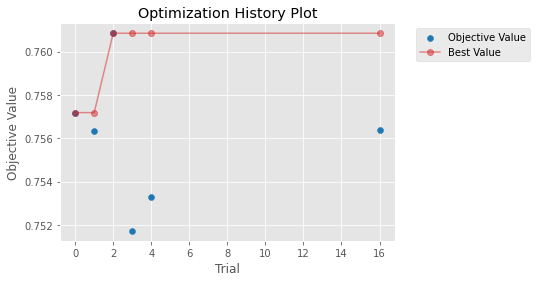

In [38]:
plot_optimization_history(study)

## Training the final model on the best parameters.

In [39]:
final_lgbm = lgbm.LGBMClassifier(objective='binary',**best_lgbm_params)
final_lgbm.fit(X_train_std,y_train)

LGBMClassifier(colsample_bytree=0.4, learning_rate=0.19518937330800934,
               max_depth=7, min_child_samples=3300,
               min_split_gain=5.816960456524854, n_estimators=10000,
               num_leaves=1480, objective='binary', reg_alpha=25, reg_lambda=15,
               subsample=0.9, subsample_freq=1)

## Predicting on the test dataset and downloading submission csv file.

In [40]:
final_preds = final_lgbm.predict_proba(X_test_std)[:,1]
submission_df =application_test[['SK_ID_CURR']]
submission_df['TARGET'] = final_preds
submission_df.to_csv('FinalLGBM.csv',index=False)

## This model achieved an roc_auc score of 0.753 on only 1 data file out of 7.